# Análise do Customer Experience da Pichau informática

Nesse notebook nós vamos indentificar as proncipais falhas no CX da pichau. Isso será feito a partir das avaliações
feitas pelos clientes nos sites https://www.reclameaqui.com.br/ e https://www.ebit.com.br/

### Configurando o notebook e instalando as dependências

In [5]:
!pip install selenium
!apt-get update
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

# Importando as bibliotecas
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from selenium import webdriver
import pandas as pd
import time

import os

driver_path = os.getcwd() + "/drivers/chromedriver"

# Configurações do Selenium
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome = webdriver.Chrome(driver_path, chrome_options=chrome_options)

/bin/bash: pip: command not found
Reading package lists... Done
E: Could not open lock file /var/lib/apt/lists/lock - open (13: Permission denied)
E: Unable to lock directory /var/lib/apt/lists/
W: Problem unlinking the file /var/cache/apt/pkgcache.bin - RemoveCaches (13: Permission denied)
W: Problem unlinking the file /var/cache/apt/srcpkgcache.bin - RemoveCaches (13: Permission denied)
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
cp: cannot stat '/usr/lib/chromium-browser/chromedriver': No such file or directory


<ipython-input-5-f3179971db5d>:22: DeprecationWarning: use options instead of chrome_options
  chrome = webdriver.Chrome(driver_path, chrome_options=chrome_options)


## Coletando as avaliações do Ebit


In [6]:
ebit_pichau_link = "https://www.ebit.com.br/pichau-informatica"
chrome.get(ebit_pichau_link)

# Adicionando um delay para carregar a página
time.sleep(2)

# Filtrando os comentários positivos
positive_btn_xpath = "/html/body/div/div/div[3]/div/div[1]/ul/li[2]"
chrome.find_element_by_xpath(positive_btn_xpath).click()

time.sleep(2)

positive_commentary_element_list = chrome.find_elements_by_class_name("user-commentary")
positive_review_text_list = [element.text for element in positive_commentary_element_list]

# Filtrando os comentários negativos
negative_btn_xpath = "/html/body/div/div/div[3]/div/div[1]/ul/li[3]"
chrome.find_element_by_xpath(negative_btn_xpath).click()

time.sleep(2)

negative_commentary_element_list = chrome.find_elements_by_class_name("user-commentary")
negative_review_text_list = [element.text for element in negative_commentary_element_list]

# Fechando o navegador
chrome.quit()

# Criando uma tabela com os cometários
ebit_review_df = pd.DataFrame(
    {
        "Positivos": positive_review_text_list,
        "Negativos": negative_review_text_list
    }
)

# Salvando os dados
ebit_review_df.to_csv("ebit-reviews.csv", index=False)

ebit_review_df.head()

,Positivos,Negativos
0,"""Melhor loja online de informática do Brasil, ...","""Só o preço q não gostei está muito caro ultim..."
1,"""já fiz compras antes então já confio""","""Eles precisam urgentemente resolver o problem..."
2,"""Preço do produto bom, site ótimo com bastante...","""Deixa eu terminar de fazer a minha compra che..."
3,"""até agora tudo perfeito""","""Site cheio de produtos indisponíveis. Deveria..."
4,"""Boa""","""Pc veio com defeito, porem o atendimento foi ..."


### Coletando as avaliações do ReclameAqui
a coleta dos dados do ReclameAqui foi feita a partir desse repositório do GitHub https://github.com/gutessitore/ReclameAquiScrapper

In [7]:
# Lendo os dados
reclame_aqui_review_df = pd.read_csv("pichau-reviews.csv")

# Separando as informações existentes
reclame_aqui_review_df[["review", "date", "city", "?"]] = reclame_aqui_review_df.review.str.split("|", expand=True)
reclame_aqui_review_df.drop("?", axis=1, inplace=True)
reclame_aqui_review_df[["review", "status"]] = reclame_aqui_review_df.review.str.rsplit("\n", 1, expand=True)

reclame_aqui_review_df.head()

,review,link,date,city,status
0,Demora no envio\nExecutei uma compra de uma ca...,https://www.reclameaqui.com.br/pichau-informat...,Há 34 minutos,Taió,Não respondida
1,Placa de video fazendo um barulho estranho e d...,https://www.reclameaqui.com.br/pichau-informat...,Há 1 hora,Jaú,Não respondida
2,Aguardando Coleta da Transportadora HÁ DIAS!\n...,https://www.reclameaqui.com.br/pichau-informat...,Há 11 horas,Cascavel,Não respondida
3,RMA com atraso\nEntreguei um teclado para RMA ...,https://www.reclameaqui.com.br/pichau-informat...,Há 13 horas,Joinville,Não respondida
4,Paguei pelo produto e não enviam\nComprei 3 pl...,https://www.reclameaqui.com.br/pichau-informat...,Há 18 horas,Bauru,Não respondida


## Análise de palavras das avaliaçoes dos sites

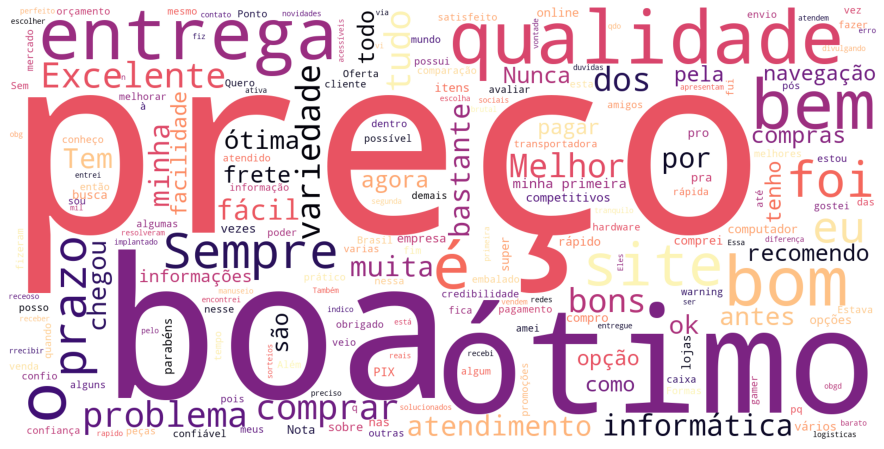

In [11]:
compliment_text = " ".join(ebit_review_df.Positivos)  # Juntando os reviews em um unico texto

stopwords = set(STOPWORDS)  # Adicionando um filtro de palavras
stopwords.update(
    ["da", "meu", "em", "você", "de", "ao", "os", "na", "loja",
     "produto", "produtos", "pichau", "já", "tive", "comum", "ainda",
     "que", "não", "para", "um", "mas", "mais", "uma", "compra", "muito", "e"]
    )  # Palavras que serão filtradas

wordcloud = WordCloud(stopwords=stopwords,
                      background_color='white', colormap='magma', width=1600,
                      height=800).generate(compliment_text)  # Gerando o wordcloud

fig, ax = plt.subplots(figsize=(16,8))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
plt.imshow(wordcloud);

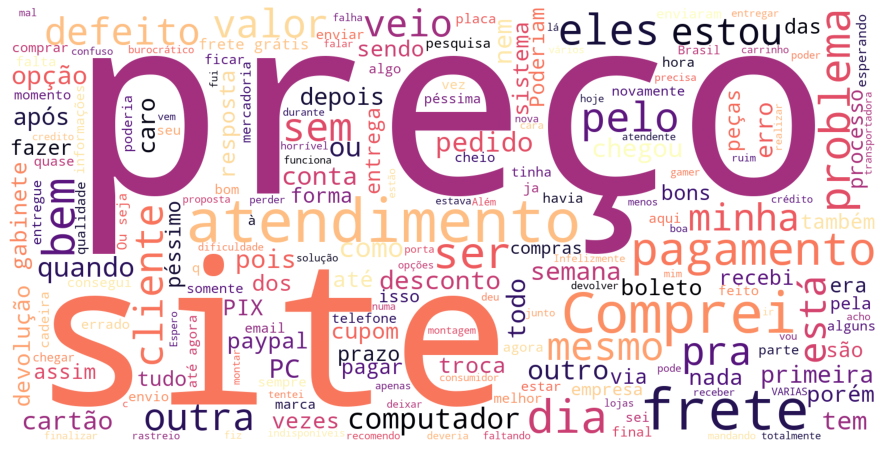

In [13]:
reclamaçao_text = " ".join(ebit_review_df.Negativos)  # Juntando os reviews em um unico texto

stopwords.update(
    ["da", "meu", "em", "você", "de", "ao", "os", "na", "loja",
     "produto", "produtos", "pichau", "já", "tive", "comum", "ainda",
     "que", "não", "para", "um", "mas", "mais", "uma", "compra", "por",
     "foi", "só", "se", "ele", "ter", "essa", "eu", "muito", "e", "o",
     "é"]
    )

wordcloud_rec = WordCloud(stopwords=stopwords, width=1600,
                      background_color='white', colormap='magma',
                      height=800).generate(reclamaçao_text)

fig, ax = plt.subplots(figsize=(16,8))
ax.imshow(wordcloud_rec, interpolation='bilinear')
ax.set_axis_off()
plt.imshow(wordcloud_rec);

In [10]:
def find_word(lista, palavra):
  return [review for review in lista if palavra in review]



preco_compliment = find_word(ebit_review_df.Positivos, "preço")
preco_rec = find_word(ebit_review_df.Negativos, "preço")

preco_compliment, preco_rec


(['"Nunca tive problema com a Pichau, mesmo quando recebi algum produto com erro, entrei em contato e sempre resolveram meu problema. Eles tem um ótimo preço e me atendem super bem com um ótimo prazo."',
  '"Essa foi minha primeira compra no site da pichau e estou satisfeito com minha compra, encontrei produtos e preços acessíveis ao meu orçamento e que apresentam ser de ótima qualidade."',
  '"Boa loja, bons preços e promoções, ótimo atendimento e bastante ativa nas redes sociais divulgando promoções, sorteios e novidades"',
  '"Loja confiável , com bons produtos e preços competitivos."',
  '"Sempre compro produtos de informática na PICHAU. Tem ótimos preços e ofertas. Também confio na qualidade dos produtos que vendem. Recomendada."',
  '"Os preços da Pichau são muito bons, a opção de comprar com 2 cartões ajuda muito na hora de comprar, já que não tenho um único cartão com limite alto"',
  '"Tem uma variedade de produtos muito boa, e normalmente com um preço coerente"',
  '"Mesmo es